# Iterating  example

The following is a brief example of using the gWOT package to infer laws on paths from time-series observations of a diffusion-drift process with branching.


In [ ]:
pip install gwot pot pykeops pathos 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad, Variable
import autograd
import autograd.numpy as np
import copy
import scipy as sp
from scipy import stats
from sklearn import metrics
import sys
import ot
import gwot
from gwot import sim, util
import gwot.bridgesampling as bs

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

In [142]:
# setup simulation parameters
dim = 2 # dimension of simulation
sim_steps = 100 # number of steps to use for Euler-Maruyama method
T = 100 # number of timepoints
N = 10 # number of particles per timepoint
D = 0.001 # diffusivity
t_final = 0.75 # simulation run on [0, t_final]

In [143]:
delta_t = t_final/(T)

In [144]:
# setup potential function
def Psi(x, t, dim = dim):
    x0 = 1.15*np.array([1, 1] + [0, ]*(dim - 2))
    x1 = -np.array([1, 1] + [0, ]*(dim - 2))
    return np.sum((x - x0)*(x - x0), axis = -1) * np.sum((x - x1)*(x - x1), axis = -1)
# get gradient 
dPsi = autograd.elementwise_grad(Psi)

In [145]:
A = np.identity(dim)
for i in range(0,dim-1):
    A[i,i+1] = 5

In [146]:

# setup potential function
def linear(x, t, dim = dim):
    # print(x.shape) it should have dimension n * dim
    return np.sum((x@A)*x, axis =1)
# get gradient 
dlin = autograd.elementwise_grad(linear)

In [147]:
def linear2(x, t, dim=dim):
    res = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        # print("this is with shape: ",val.shape, val)
        res[i] = (x[i,:].T @ A @ x[i,:])._value
        # res[i] = x[i,:].T @ A @ x[i,:]
    return res
dlin2 = autograd.elementwise_grad(linear2)

In [148]:
def drift(x,t, dim=dim):
    return (A @ x.T).T

Simulation tries to simulate $dX_t = -\nabla \Phi(X_t)dt + \sigma dB_t$ It's not a general simulation (details found in util.py sde integrate function)

In [149]:
# branching rates
beta = lambda x, t: 5*((np.tanh(2*x[0]) + 1)/2)
delta = lambda x, t: 0

# function for particle initialisation
ic_func = lambda N, d: np.random.randn(N, d)*0.1 + 1

# setup simulation object
sim = gwot.sim.Simulation(V = None, dV = drift, birth_death = True, 
                          birth = beta, 
                          death = delta,
                          N = np.repeat(N, T), 
                          T = T, 
                          d = dim, 
                          D = D, 
                          t_final = t_final, 
                          ic_func = ic_func, 
                          pool = None)

# sample from simulation
sim.sample(steps_scale = int(sim_steps/sim.T), trunc = N);

Text(0, 0.5, 'dim 1')

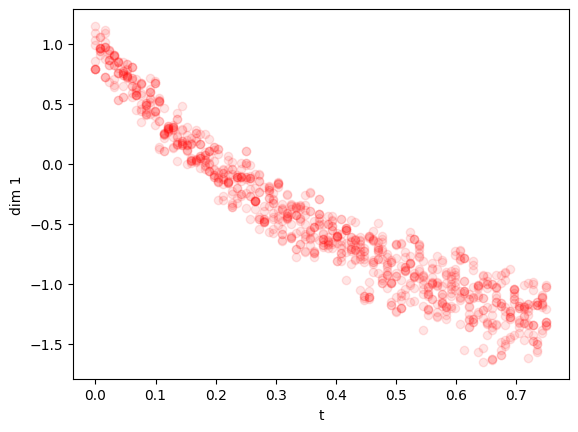

In [150]:
# plot samples
plt.scatter(np.kron(np.linspace(0, t_final, T), np.ones(N)), sim.x[:, 0], alpha = 0.1, color = "red")
plt.xlabel("t"); plt.ylabel("dim 1")

In [151]:
# sample ground truth paths
# sampling trajectories from the Simulation object ignores the branching
paths_gt = sim.sample_trajectory(steps_scale = int(sim_steps/sim.T), N = N)

In [152]:
X1_real = paths_gt[:,0,:] # N * dim
X2_real = paths_gt[:,1,:]

Don't transpose points dlin function gets input $N \times dim$ and dlin(X1_real, 1) is equal to $(A + A^T) \times  X1_{real}^T)^T$

In [153]:
X2_real - X1_real + drift(X1_real,1) * delta_t

array([[ 3.74620114e-03, -8.29216371e-04],
       [-4.37387999e-03,  1.77125317e-03],
       [ 4.38447431e-05,  8.11873936e-04],
       [-4.83702605e-03, -2.77299215e-03],
       [ 9.53746884e-04,  1.18778300e-03],
       [-2.07666103e-03, -7.84450569e-04],
       [ 2.82874856e-03, -4.34643169e-03],
       [ 6.85011684e-04, -1.16521888e-03],
       [-3.00620297e-03,  8.65335627e-04],
       [-2.96892590e-03, -6.88958646e-04]])

experiment with $\sigma=0$ for checking the data is ok. ((X2_real - X1_real ) +drift(X1_real,1)*delta_t)

In [154]:
paths_gt.shape

(10, 100, 2)

In [155]:
import numpy as np
from scipy.optimize import minimize

# Define the objective function
def objective_consecutive(A_flat):
    A = A_flat.reshape(dim, dim)
    return np.sum((X2_real - X1_real + (A @ X1_real.T * delta_t).T) ** 2)
def objective_general(A_flat):
    A = A_flat.reshape(dim, dim)
    loss = 0
    for i in range(T-1):
        X1 = paths_gt[:,i,:]
        X2 = paths_gt[:,i+1,:]
        loss+= np.sum((X2 - X1 + (A @ X1.T * delta_t).T) ** 2)
    return loss
    

# Initial guess for A
A0 = np.zeros(dim**2)

# Optimize using scipy.optimize.minimize
result_general = minimize(objective_general, A0, method='L-BFGS-B')
result_consecutive = minimize(objective_consecutive, A0, method='L-BFGS-B')


# Print the optimal value for A
A_optimal_general = result_general.x.reshape(2, 2)

print("general solution",A_optimal_general)
A_optimal_consecutive = result_consecutive.x.reshape(2, 2)
print("consecutive solution",A_optimal_consecutive)

general solution [[0.99796246 4.99543979]
 [0.01343716 1.02542319]]
consecutive solution [[-0.19715604  6.32199468]
 [ 0.078009    1.00246141]]


In [22]:
def loss_function(w, alpha = 1):
    
    tmp = np.zeros(X1_real.shape)
    for i in range(X1_real.shape[1]):
       tmp[:,i] = list[i]@w
    # alpha * np.sum(np.abs(w))
    return np.linalg.norm(X2_real-X1_real - tmp) 

In [23]:
from scipy.optimize import minimize
w = np.zeros(dim**2)
res = minimize(loss_function, w, method='BFGS', tol=1e-9)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 100)

In [244]:
X1=sim.x[sim.t_idx == 0]
X1

array([[0.86673057, 1.13157142],
       [0.86673057, 1.13157142],
       [0.90255277, 0.88803624],
       [1.32727872, 0.87202088],
       [0.86673057, 1.13157142],
       [0.98690161, 0.97629713],
       [0.99912315, 0.86899122],
       [1.32727872, 0.87202088],
       [0.77085189, 1.02924718],
       [0.99912315, 0.86899122]])

In [211]:
X1_real - X1

array([[ 0.00977696,  0.1402145 ],
       [ 0.11342328, -0.09494823],
       [-0.17155816,  0.06737489],
       [ 0.26938195, -0.08009206],
       [-0.0947194 , -0.00409148],
       [ 0.30680765, -0.1129711 ],
       [ 0.01428477,  0.12844531],
       [ 0.22264189,  0.06129508],
       [-0.07134901,  0.0047029 ],
       [ 0.12620373,  0.00751398]])

In [251]:
X1=sim.x[sim.t_idx == 0]
X2=sim.x[sim.t_idx == 1]
C = ot.utils.dist(X1, X2)
C = C / np.median(C)

T = ot.sinkhorn(ot.utils.unif(X1.shape[0]), ot.utils.unif(X2.shape[0]), C, 0.0000000000001)

In [252]:
X1.shape

(10, 2)

In [253]:
np.sum(T)

0.0

In [254]:
T

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [188]:
def make_Matrics(Xi):
    n = len(Xi)
    # print(n)
    X = np.zeros((n,n**2))
    for i in range(0,n):
        X[i, i*n :i*n + n] = Xi
    return X

    

In [189]:
n = dim
y = np.zeros((dim* N**2))
for i in range(0,N):
    for j in range(0,N):
        # print((X1[i,:] - X2[j,:])* np.sqrt(T[i,j]))
        y[i*(n*N) + j*n:i*(n*N) + j*n+n] = (X1[i,:] - X2[j,:])* np.sqrt(T[i,j])


In [190]:
X = np.zeros((n*N**2,n**2))
differ = 0.75/2
for i in range(0,N):
    sub_matrix = make_Matrics(X1[i,:])
    for j in range(0,N):
        X[i*(n*N) + j*n:i*(n*N) + j*n+n,:] = sub_matrix * np.sqrt(T[i,j])*differ


In [191]:
X

array([[1.84002292e-04, 2.37477894e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.84002292e-04, 2.37477894e-04],
       [2.34522137e-20, 3.02680051e-20, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 1.89542924e-13, 2.94381934e-13],
       [8.20468802e-08, 1.27428230e-07, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.20468802e-08, 1.27428230e-07]])

In [192]:
y

array([3.46299918e-04, 3.72758353e-04, 5.19664368e-21, ...,
       6.96721769e-13, 1.09815868e-07, 2.61945235e-07])

In [193]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.0000001)
clf.fit(X,y)
w = clf.coef_

In [194]:
w

array([0., 0., 0., 0.])

In [176]:
A

array([[1., 2.],
       [0., 1.]])